In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle

with open('../paper_calculations/aligned_reconstruction_wo_tw_errors.pickle', 'rb') as handle:
      aligned_reconstruction_wo_tw_errors = pickle.load(handle)
        
keys = [a[1] for a in aligned_reconstruction_wo_tw_errors]
values = [a[2:] for a in aligned_reconstruction_wo_tw_errors]

aligned_notw_errors_dict = dict(zip(keys,values))

In [3]:
aligned_notw_errors_dict.keys()

dict_keys(['results/rescaled/20231104-100412.359088/savedmodel', 'results/rescaled/20231104-093444.048134/savedmodel', 'results/rescaled/20231104-090337.680577/savedmodel', 'results/rescaled/20231104-083412.289409/savedmodel', 'results/rescaled/20231104-080302.880192/savedmodel', 'results/rescaled/20231104-073329.574634/savedmodel', 'results/rescaled/20231104-070215.094839/savedmodel', 'results/rescaled/20231104-063241.710530/savedmodel', 'results/rescaled/20231104-060134.269789/savedmodel', 'results/rescaled/20231104-053208.525761/savedmodel', 'results/rescaled/20231104-050059.141537/savedmodel', 'results/rescaled/20231104-043128.802151/savedmodel', 'results/rescaled/20231104-040016.323010/savedmodel', 'results/rescaled/20231104-033047.838953/savedmodel', 'results/rescaled/20231104-025945.446865/savedmodel', 'results/rescaled/20231104-023020.113210/savedmodel', 'results/rescaled/20231104-015911.736405/savedmodel', 'results/rescaled/20231104-012949.148861/savedmodel', 'results/rescaled

In [4]:
def clean(rawdata):
    return rawdata.replace("'","\"").replace("False","0").replace("True","1").replace("None","\"None\"")

In [5]:
def safe_check_required_key_value(dictionary, key, value):
    return key in dictionary.keys() and dictionary[key] == value

In [6]:
def match_dict_values(curdict, goaldict, ignore_keys_list):
    for key in goaldict.keys():
        if key not in ignore_keys_list:
            if not safe_check_required_key_value(curdict, key, goaldict[key]):
                return False
    return True

In [7]:
def get_all_data():
    rawdata1 = pd.read_csv("../project.csv")
    rawdata1 = rawdata1.reset_index()  # make sure indexes pair with number of rows

    rawdata2 = pd.read_csv("../projectrateinvariantvae.csv")
    rawdata2 = rawdata2.reset_index()  # make sure indexes pair with number of rows


    rawdata = pd.concat([rawdata1,rawdata2])
    rawdata.reset_index()
    return rawdata

In [8]:
rawdata = get_all_data()

all_run_dicts = []

for index, row in rawdata.iterrows():
    configdict = json.loads(clean(row.config))
    if not any([match_dict_values(configdict, prd,["logname","model_save_dir","latent_dim"]) for prd in all_run_dicts]):
        # "convolutional_decoder" is deprecated. use "convolutional_decoder_upsampling" results instead
        if configdict["decoder_name"] != "convolutional_decoder":
            all_run_dicts.append(configdict)

In [9]:
all_run_dicts

[{'beta': 0.0005,
  'dtype': 'torch.float32',
  'device': 'cuda',
  'logname': 'results/rescaled/20231104-100412.359088/log',
  'useAdam': 1,
  'datafile': 'data/trainTest2DLetterARescaled.npz',
  'traj_len': 200,
  'batch_size': 64,
  'latent_dim': 14,
  'num_epochs': 20000,
  'dec_use_elu': 1,
  'decoding_lr': 0.0001,
  'encoding_lr': 0.0001,
  'decoder_name': 'functional_decoder_complicated',
  'decoding_eps': 0.0001,
  'encoder_name': 'convolutional_encoder',
  'encoding_eps': 0.0001,
  'traj_channels': 2,
  'model_save_dir': 'results/rescaled/20231104-100412.359088/savedmodel',
  'step_each_batch': 1,
  'dec_use_softplus': 0,
  'emb_nonlinearity': 'ReLU',
  'log_to_wandb_name': 'rescaled',
  'scalar_timewarping_lr': 0,
  'learn_decoder_variance': 0,
  'scalar_timewarper_name': 'identity_scalar_timewarper',
  'scalar_timewarping_eps': 1e-06,
  'vector_timewarper_name': 'dtw_vector_timewarper',
  'emb_conv_layers_strides': [1, 2, 2, 2],
  'emb_dropout_probability': 0,
  'curv_loss_p

In [10]:
# This was used to debug and figure out that this run was aborted before it completed,
# so there was no saved model associated with it
#weirdrunname = '../results/rateinvariantvae/20231114-204924.596986/savedmodel'
#
#
#weird_run = [a for a in all_run_dicts if a["model_save_dir"] == weirdrunname]
#
#for index, row in rawdata.iterrows():
#    configdict = json.loads(clean(row.config))
#    rowdata = json.loads(clean(row.summary))
#    if configdict["model_save_dir"] != weirdrunname:
#        #print(weird_run)
#        #print(row.summary)

In [11]:
def create_dataset_combine(sweep_dictionaries,ignore_keys_list = ["logname","model_save_dir","latent_dim"]):
    all_data = []
    for sweep_dictionary in sweep_dictionaries:
        data = create_dataset(sweep_dictionary,ignore_keys_list)
        all_data.append(data)
    all_data = np.concatenate(all_data, axis=0)
    return all_data

In [12]:
# add a default maxstamp so results don't change if we add more results
def create_dataset(sweep_dictionary,ignore_keys_list = ["logname","model_save_dir","latent_dim"], maxstamp = None):
    data = []
    data_timestamps = []
    rawdata = get_all_data()

    for index, row in rawdata.iterrows():
        configdict = json.loads(clean(row.config))
        if match_dict_values(configdict,sweep_dictionary,ignore_keys_list):
            rowdata = json.loads(clean(row.summary))
            if "train_alignedRMSE" in rowdata.keys() and rowdata["_step"] >= 199:
                if maxstamp is None or configdict["logname"][-26:-4] <= maxstamp:
                    save_key = configdict["model_save_dir"]
                    data.append((configdict["latent_dim"],
                                 aligned_notw_errors_dict[save_key][0],#rowdata["train_alignedRMSE"],
                                 aligned_notw_errors_dict[save_key][0],#rowdata["test_alignedRMSE"],
                                 rowdata["train_noiselessRMSE"],
                                 rowdata["test_noiselessRMSE"],
                                 rowdata["train_KLD"]))
                    data_timestamps.append(configdict["logname"][-26:-4])
    data = np.array(data) 
    data_timestamps=np.array(data_timestamps)
    return data, data_timestamps

In [13]:
datasets = [create_dataset(rd,maxstamp=None) for rd in all_run_dicts]

In [14]:
def plot_with_average_variance_line(ax,data,color,label,markerstyle,stamps,allow_partial):
    #ax.scatter(data[:,0],data[:,1],c=color,alpha=1,marker=markerstyle)
    xvals = []
    yvals = []
    times = []
    stdyvals = []
    for x,y in data:
        if x not in xvals:
            matching_inds = np.where(data[:,0]==x)[0]
            corresponding_stamps = stamps[matching_inds]
            if (not allow_partial) and len(corresponding_stamps) < 5:
                continue
            xvals.append(x)
            most_recent_stamps = np.argsort(corresponding_stamps)[-5:]
            most_recent_matching_data = data[matching_inds[most_recent_stamps]]
            yvals.append(np.mean(most_recent_matching_data[:,1]))
            stdyvals.append(np.std(most_recent_matching_data[:,1]))
    xvals = np.array(xvals)
    yvals = np.array(yvals)
    stdyvals = np.array(stdyvals)
    order = np.argsort(xvals)
    if len(xvals) == 0:
        return
    ax.plot(xvals[order],yvals[order],c=color,label=label,zorder=2)
    ax.scatter(xvals[order],yvals[order],c=color,alpha=1,marker=markerstyle,s=100,edgecolors= "k",linewidth=1,zorder=3)
    ax.fill_between(xvals[order], yvals[order]-stdyvals[order], yvals[order]+stdyvals[order], facecolor=color, alpha=0.5,zorder=1)
    

In [15]:
dmpresults = np.load("../paper_calculations/dmpmodels/dmp_results_simple.npy")
dmpresults = dmpresults[dmpresults[:,0]>0]
dmpresults = dmpresults[dmpresults[:,0]<17]
# repeat five times with dummy dates so that these are plotted correctly (not filtered out for too few runs)
datasets.append((dmpresults.repeat(5,0),np.ones(len(dmpresults)).repeat(5,0)))

In [16]:
dmpresults

array([[ 1.        ,  0.67860103,  0.66613074,  0.92280638,  0.92664313],
       [ 2.        ,  0.63807743,  0.62368892,  0.83348037,  0.82446318],
       [ 3.        ,  0.60715319,  0.60487168,  0.78222608,  0.78570117],
       [ 4.        ,  0.56911967,  0.57712289,  0.74087928,  0.75141257],
       [ 5.        ,  0.43192342,  0.42694624,  0.60283102,  0.59613211],
       [ 6.        ,  0.40821406,  0.41280948,  0.56238612,  0.56586862],
       [ 7.        ,  0.3904214 ,  0.39956524,  0.52944707,  0.53485682],
       [ 8.        ,  0.37721482,  0.38967196,  0.50013865,  0.51203511],
       [ 9.        ,  0.30605797,  0.30391475,  0.42789217,  0.43109513],
       [10.        ,  0.28227167,  0.28781444,  0.40142251,  0.40941302],
       [11.        ,  0.26764103,  0.27545993,  0.37393668,  0.38616809],
       [12.        ,  0.25333944,  0.26559837,  0.35250012,  0.36789292],
       [13.        ,  0.24837707,  0.26251429,  0.34083044,  0.35847263],
       [14.        ,  0.24402864,  0.2

In [17]:

pcaresults = np.load("../paper_calculations/pca_results.npy")
pcaresults = pcaresults[pcaresults[:,0]>0]
pcaresults = pcaresults[pcaresults[:,0]<17]
# repeat five times with dummy dates so that these are plotted correctly (not filtered out for too few runs)
datasets.append((pcaresults.repeat(5,0),np.ones(len(pcaresults)).repeat(5,0)))

In [18]:
pcaresults

array([[ 7.        ,  0.23619156,  0.25728166,  0.29821906,  0.32056869],
       [ 3.        ,  0.40895737,  0.40585962,  0.57717282,  0.6039258 ],
       [12.        ,  0.1413782 ,  0.15936161,  0.16798055,  0.18708351],
       [14.        ,  0.11601232,  0.12774557,  0.13700881,  0.14877522],
       [ 5.        ,  0.28269044,  0.29918769,  0.37752277,  0.39410322],
       [10.        ,  0.17019653,  0.18623369,  0.20588736,  0.21946136],
       [ 4.        ,  0.30566087,  0.31831356,  0.45359113,  0.46071272],
       [13.        ,  0.12629174,  0.14169268,  0.1486366 ,  0.16483182],
       [15.        ,  0.09999882,  0.11186026,  0.11976503,  0.13105871],
       [ 6.        ,  0.2535611 ,  0.27432832,  0.33467209,  0.35754651],
       [ 9.        ,  0.18900098,  0.20355853,  0.22974555,  0.24068698],
       [11.        ,  0.15129604,  0.17175349,  0.18307892,  0.20282987],
       [16.        ,  0.09125001,  0.10098888,  0.10820178,  0.11675121],
       [ 2.        ,  0.5208527 ,  0.4

In [19]:
datasets[-1]

(array([[ 7.        ,  0.23619156,  0.25728166,  0.29821906,  0.32056869],
        [ 7.        ,  0.23619156,  0.25728166,  0.29821906,  0.32056869],
        [ 7.        ,  0.23619156,  0.25728166,  0.29821906,  0.32056869],
        [ 7.        ,  0.23619156,  0.25728166,  0.29821906,  0.32056869],
        [ 7.        ,  0.23619156,  0.25728166,  0.29821906,  0.32056869],
        [ 3.        ,  0.40895737,  0.40585962,  0.57717282,  0.6039258 ],
        [ 3.        ,  0.40895737,  0.40585962,  0.57717282,  0.6039258 ],
        [ 3.        ,  0.40895737,  0.40585962,  0.57717282,  0.6039258 ],
        [ 3.        ,  0.40895737,  0.40585962,  0.57717282,  0.6039258 ],
        [ 3.        ,  0.40895737,  0.40585962,  0.57717282,  0.6039258 ],
        [12.        ,  0.1413782 ,  0.15936161,  0.16798055,  0.18708351],
        [12.        ,  0.1413782 ,  0.15936161,  0.16798055,  0.18708351],
        [12.        ,  0.1413782 ,  0.15936161,  0.16798055,  0.18708351],
        [12.        ,  0.

In [20]:
import matplotlib.lines as mlines 
#https://stackoverflow.com/questions/47391702/how-to-make-a-colored-markers-legend-from-scratch

In [21]:
import pickle


In [22]:
def save_plots(namebase,rateylim,toplot = None,labels=None,colors=None,shapes=None,labeltextcolor="white",allow_partial=False):
    
    fsize=(8,6)
    odds = [i for i in range(1,17) if i % 5 == 1]
    
    
    if toplot is None:
        toplot = range(len(datasets))
    if labels is None:
        labels = toplot
    if colors is None:
        colors = [f"C{i}" for i in range(len(labels))]
    if shapes is None:
        shapes = ["o"] * len(datasets)
        
    print((toplot,labels,colors,shapes))
        
    f = plt.figure(figsize=fsize)
    ax = f.add_axes([0.1, 0.1, 0.8, 0.8])  # add the left Axes
    for i,label,color,shape in zip(toplot,labels,colors,shapes):
        dataval, stamps = datasets[i]
        if len(dataval.shape) > 1 and dataval.shape[1] > 5: # No KL for PCA
            plotdat = np.copy(dataval[:,(0,5)])
            plotdat[:,1] = np.log2(plotdat[:,1])
            plot_with_average_variance_line(ax, plotdat, color,label=f"{label}",markerstyle=shape, stamps=stamps,allow_partial=allow_partial)
    ax.set_ylim(2,np.log2(rateylim))
    ax.set_xlim(0.5,16.5)
    ax.set_xticks(odds,odds)
    ax.set_xticks(range(1,17),minor=True)
    plt.savefig(f"{namebase}LatentSweepRate.pdf",bbox_inches="tight")
    
    f = plt.figure(figsize=fsize)
    ax = f.add_axes([0.1, 0.1, 0.8, 0.8])  # add the left Axes
    for i,label,color,shape in zip(toplot,labels,colors,shapes):
        dataval, stamps = datasets[i]
        if len(dataval.shape) > 1:
            plot_with_average_variance_line(ax, dataval[:,(0,1)],color,label=f"{label}",markerstyle=shape, stamps=stamps,allow_partial=allow_partial)
    ax.set_ylim(0,1.2)
    ax.set_xlim(0.5,16.5)
    ax.set_xticks(odds,odds)
    ax.set_xticks(range(1,17),minor=True)
    plt.savefig(f"{namebase}LatentSweepTrain.pdf",bbox_inches="tight")
    
    f = plt.figure(figsize=fsize)
    ax = f.add_axes([0.1, 0.1, 0.8, 0.8])  # add the left Axes
    legend_lines = []
    for i,label,color,shape in zip(toplot,labels,colors,shapes):
        dataval, stamps = datasets[i]
        if len(dataval.shape) > 1:
            plot_line_info = plot_with_average_variance_line(ax, dataval[:,(0,2)],color,label=f"{label}",markerstyle=shape, stamps=stamps,allow_partial=allow_partial)
            legend_lines.append(
                mlines.Line2D([], [], color=color, marker=shape, label=f"{label}",markersize=10,markeredgecolor= "k",markeredgewidth=1))
            
    ax.set_ylim(0,1.2)
    ax.set_xlim(0.5,16.5)
    ax.set_xticks(odds,odds)
    ax.set_xticks(range(1,17),minor=True)
    plt.legend(handles=legend_lines,labelcolor=labeltextcolor, frameon=False,labelspacing=0.4)
    plt.savefig(f"{namebase}LatentSweepTest.pdf",bbox_inches="tight")
    plt.show()

In [23]:
def is_base_config(testdict,must_not_match=[]):
    checks = [("beta",0.001),
                ("scalar_timewarper_name","modeled_scalar_timewarper"),
                ("decoder_name","functional_decoder_complicated"),
                ("dec_complicated_function_hidden_dims",[200]),
                ("training_data_added_timing_noise",0.1),
                ("vector_timewarper_name","identity_vector_timewarper"),
                ("encoder_name", "convolutional_encoder"),
                ("use_rate_invariant_autoencoder",1),
                ("use_rate_invariant_vae",1),
                ("device","cuda"),
                ("emb_nonlinearity","ReLU")
             ]
    for check in checks:
        #print(check[0])
        if check[0] in must_not_match:
            if safe_check_required_key_value(testdict,check[0],check[1]):
                #print("The problem was NOTMATCH",testdict,check[0],check[1])
                return False
        elif not safe_check_required_key_value(testdict,check[0],check[1]):
            #print("The problem was",testdict,check[0],check[1])
            return False
    return True

In [24]:
all_run_dicts[1]

{'beta': 0.0005,
 'dtype': 'torch.float32',
 'device': 'cuda',
 'logname': 'results/rescaled/20231104-093444.048134/log',
 'useAdam': 1,
 'datafile': 'data/trainTest2DLetterARescaled.npz',
 'traj_len': 200,
 'batch_size': 64,
 'latent_dim': 14,
 'num_epochs': 20000,
 'dec_use_elu': 1,
 'decoding_lr': 0.0001,
 'encoding_lr': 0.0001,
 'decoder_name': 'convolutional_decoder_upsampling',
 'decoding_eps': 0.0001,
 'encoder_name': 'convolutional_encoder',
 'encoding_eps': 0.0001,
 'traj_channels': 2,
 'model_save_dir': 'results/rescaled/20231104-093444.048134/savedmodel',
 'step_each_batch': 1,
 'dec_use_softplus': 0,
 'emb_nonlinearity': 'ReLU',
 'log_to_wandb_name': 'rescaled',
 'scalar_timewarping_lr': 0,
 'dec_gen_first_traj_len': 25,
 'learn_decoder_variance': 0,
 'scalar_timewarper_name': 'identity_scalar_timewarper',
 'scalar_timewarping_eps': 1e-06,
 'vector_timewarper_name': 'dtw_vector_timewarper',
 'emb_conv_layers_strides': [1, 2, 2, 2],
 'emb_dropout_probability': 0,
 'curv_loss

In [25]:
[d for d in all_run_dicts if is_base_config(d,["beta","decoder_name","dec_complicated_function_hidden_dims","scalar_timewarper_name","use_rate_invariant_autoencoder","use_rate_invariant_vae"])]

[{'beta': 0.01,
  'dtype': 'torch.float32',
  'device': 'cuda',
  'logname': 'results/rescaled/20231022-093923.520499/log',
  'useAdam': 1,
  'datafile': 'data/trainTest2DLetterARescaled.npz',
  'traj_len': 200,
  'batch_size': 64,
  'latent_dim': 14,
  'num_epochs': 20000,
  'dec_use_elu': 1,
  'decoding_lr': 0.0001,
  'encoding_lr': 0.0001,
  'decoder_name': 'convolutional_decoder_upsampling',
  'decoding_eps': 0.0001,
  'encoder_name': 'convolutional_encoder',
  'encoding_eps': 0.0001,
  'traj_channels': 2,
  'model_save_dir': 'results/rescaled/20231022-093923.520499/savedmodel',
  'step_each_batch': 1,
  'dec_use_softplus': 0,
  'emb_nonlinearity': 'ReLU',
  'log_to_wandb_name': 'rescaled',
  'scalar_timewarping_lr': 0,
  'dec_gen_first_traj_len': 25,
  'learn_decoder_variance': 0,
  'scalar_timewarper_name': 'identity_scalar_timewarper',
  'scalar_timewarping_eps': 1e-06,
  'vector_timewarper_name': 'identity_vector_timewarper',
  'emb_conv_layers_strides': [1, 2, 2, 2],
  'emb_dr

In [26]:
base_config_index = np.where(np.array([is_base_config(d,("use_rate_invariant_autoencoder","use_rate_invariant_vae")) for d in all_run_dicts]))[0].item()
noise_off_index = np.where(np.array([is_base_config(d,["training_data_added_timing_noise","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0].item()
timewarp_PCA_index = np.where(np.array([is_base_config(d,["dec_complicated_function_hidden_dims","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0].item()
notimewarp_index = np.where(np.array([is_base_config(d,["scalar_timewarper_name","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0].item()

conv_index = np.where(np.array([is_base_config(d,["decoder_name","dec_complicated_function_hidden_dims","scalar_timewarper_name","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0].item()
no_noise_timewarp_PCA_index = np.where(np.array([is_base_config(d,["training_data_added_timing_noise","dec_complicated_function_hidden_dims","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0].item()
no_timewarp_PCA_index = np.where(np.array([is_base_config(d,["scalar_timewarper_name","dec_complicated_function_hidden_dims","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0].item()

beta_inds = list(np.where(np.array([is_base_config(d,["beta","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0])
no_tw_beta_inds = list(np.where(np.array([is_base_config(d,["beta","scalar_timewarper_name","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0])
conv_beta_inds = list(np.where(np.array([is_base_config(d,["beta","decoder_name","dec_complicated_function_hidden_dims","scalar_timewarper_name","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0])

dtw_index = np.where(np.array([is_base_config(d,["vector_timewarper_name", "scalar_timewarper_name","use_rate_invariant_autoencoder","use_rate_invariant_vae"]) for d in all_run_dicts]))[0].item()
#trans_index = np.where(np.array([is_base_config(d,["encoder_name","scalar_timewarper_name"]) for d in all_run_dicts]))[0].item()

ria_index = np.where(np.array([is_base_config(d,["beta","scalar_timewarper_name","decoder_name","dec_complicated_function_hidden_dims","use_rate_invariant_autoencoder","emb_nonlinearity"]) for d in all_run_dicts]))[0].item()

# 4 + 3 + 2 + 2 + 2
print(len(all_run_dicts))

37


In [27]:
print(all_run_dicts[ria_index])

{'beta': 0.01, 'dtype': 'torch.float32', 'ria_T': 199, 'device': 'cuda', 'logname': '../results/rateinvariantvae/20231115-071334.960871/log', 'useAdam': 1, 'datafile': '../data/trainTest2DLetterARescaled.npz', 'traj_len': 200, 'batch_size': 64, 'latent_dim': 14, 'num_epochs': 20000, 'dec_use_elu': 1, 'decoding_lr': 0.0001, 'encoding_lr': 0.0001, 'dec_use_tanh': 1, 'decoder_name': 'rate_invariant_conv', 'decoding_eps': 0.0001, 'encoder_name': 'convolutional_encoder', 'encoding_eps': 0.0001, 'traj_channels': 2, 'model_save_dir': '../results/rateinvariantvae/20231115-071334.960871/savedmodel', 'step_each_batch': 1, 'dec_use_softplus': 0, 'emb_nonlinearity': 'Tanh', 'force_autoencoder': 0, 'log_to_wandb_name': 'rateinvariantvae', 'dec_conv1d_padding': 'same', 'emb_conv1d_padding': 'same', 'scalar_timewarping_lr': 0, 'dec_gen_first_traj_len': 200, 'learn_decoder_variance': 0, 'scalar_timewarper_name': 'identity_scalar_timewarper', 'scalar_timewarping_eps': 1e-06, 'use_rate_invariant_vae': 1

In [28]:
def print_matching_runs(sweep_dictionary, latent_dim=16, ignore_keys_list = ["logname","model_save_dir","latent_dim"], minstamp = None):
    data = []
    data_timestamps = []
    rawdata = get_all_data()

    for index, row in rawdata.iterrows():
        configdict = json.loads(clean(row.config))
        if (match_dict_values(configdict,sweep_dictionary,ignore_keys_list)
                             and configdict["latent_dim"]==latent_dim):
            print(configdict["logname"][:-4])
            


In [29]:
for name, idval in [("timewarp:", base_config_index),
                    ("nodataaug:", noise_off_index),
                    ("nononlin:", timewarp_PCA_index),
                    ("noTimewarp:", notimewarp_index),
                    ("TimewarpVAEDTW", dtw_index),
                    ("conv",conv_index),
                    ("ria",ria_index)
                   ]:
    print(name)                
    print_matching_runs(all_run_dicts[idval])

timewarp:
results/rescaled/20231011-003229.166126
results/rescaled/20231010-031743.271161
results/rescaled/20231009-061308.267062
results/rescaled/20231008-091922.953586
results/rescaled/20231007-121820.331670
nodataaug:
results/rescaled/20231011-012031.458481
results/rescaled/20231010-040536.557571
results/rescaled/20231009-070028.259646
results/rescaled/20231008-100607.941017
results/rescaled/20231007-130444.275691
nononlin:
results/rescaled/20231011-005640.240964
results/rescaled/20231010-034148.492193
results/rescaled/20231009-063657.164376
results/rescaled/20231008-094253.906909
results/rescaled/20231007-124140.310374
noTimewarp:
results/rescaled/20231020-163255.573136
results/rescaled/20231020-101214.395043
results/rescaled/20231020-035523.438802
results/rescaled/20231019-213805.441526
results/rescaled/20231019-155125.269227
TimewarpVAEDTW
results/rescaled/20231101-235215.001584
results/rescaled/20231101-040354.404853
results/rescaled/20231029-151257.318732
results/rescaled/20231

In [30]:
import matplotlib
font = {        'size'   : 22}

matplotlib.rc('font', **font)

([23, 21, 22, 14], ['TimewarpVAE', 'ndaug', 'nnonlin', 'NoTimewarp'], ['C0', 'C1', 'C2', 'C3'], ['o', 'P', 'X', '.'])


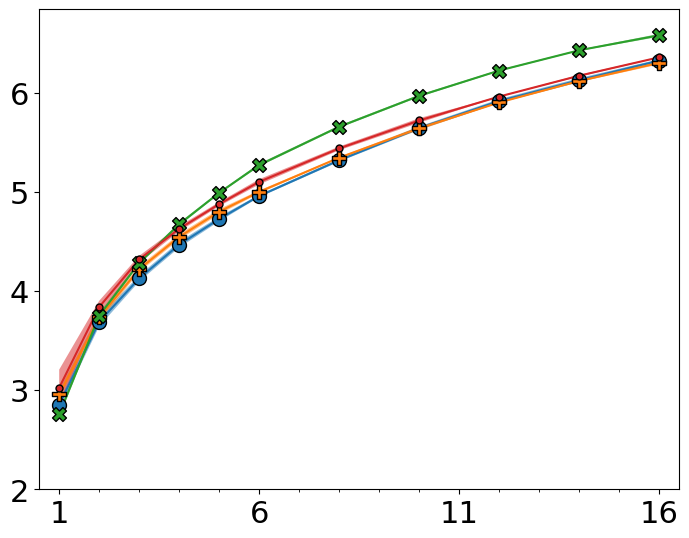

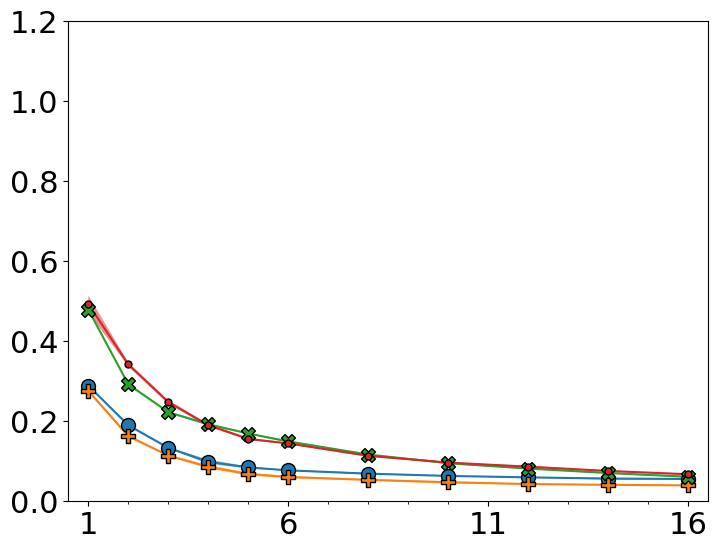

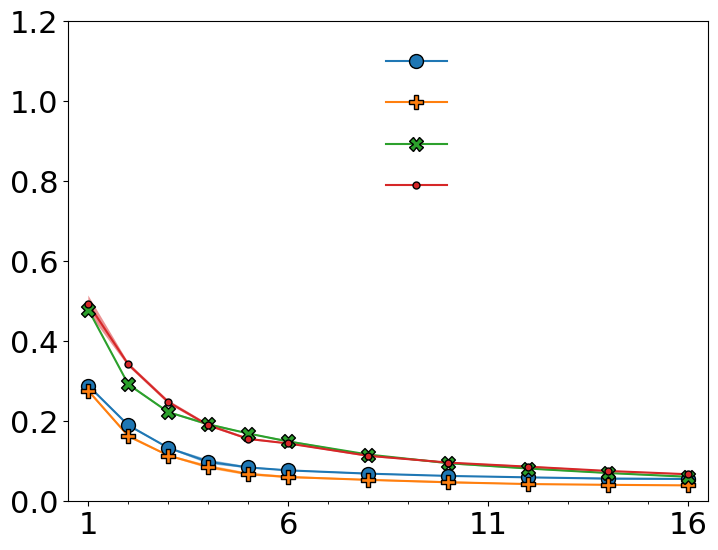

In [31]:
save_plots("ablation",rateylim=115,toplot=[base_config_index,noise_off_index,timewarp_PCA_index,notimewarp_index],
           labels=["TimewarpVAE","ndaug","nnonlin","NoTimewarp"],
          shapes=["o","P","X","."])

([23, 24, 20], ['TimewarpVAE', 'NoTWNoNonlinear', 'NoNoiseNoNonlinear'], ['C0', 'C1', 'C2'], ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])


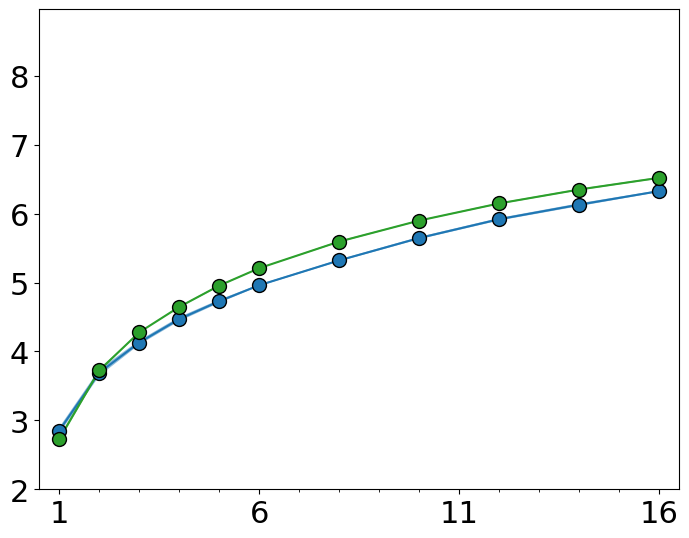

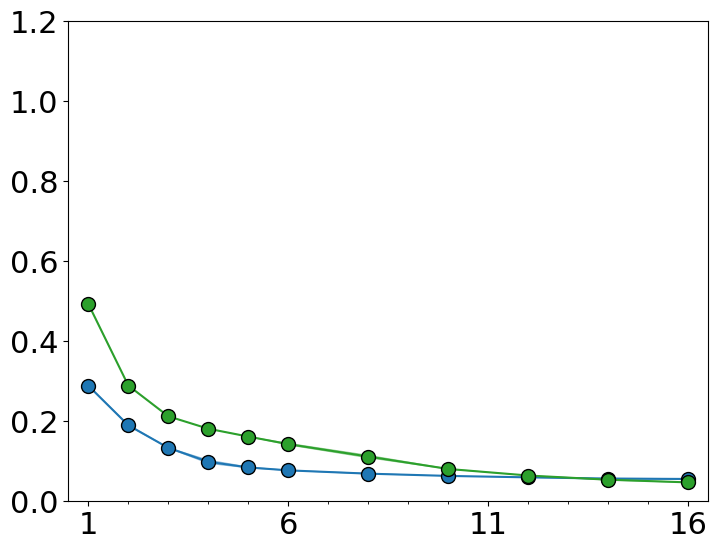

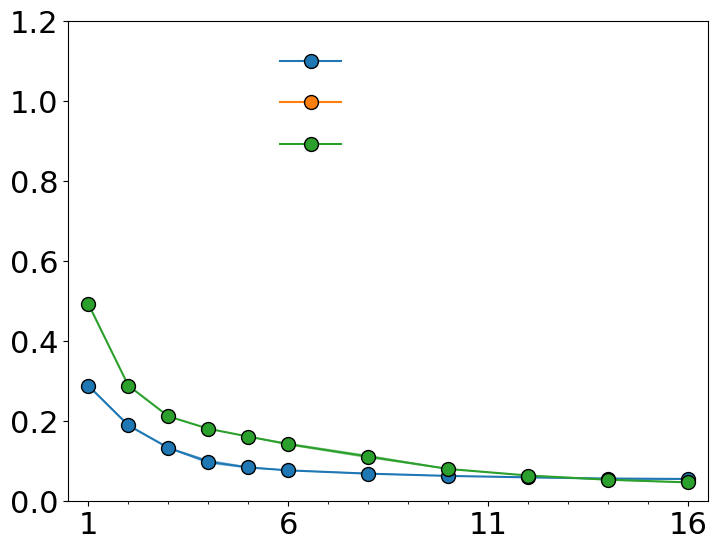

In [32]:
save_plots("conv",rateylim=500,toplot=[base_config_index,no_timewarp_PCA_index,no_noise_timewarp_PCA_index],
           labels=["TimewarpVAE","NoTWNoNonlinear","NoNoiseNoNonlinear"])

([23, 15, 18, 19], [23, 15, 18, 19], ['C0', 'C1', 'C2', 'C3'], ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])


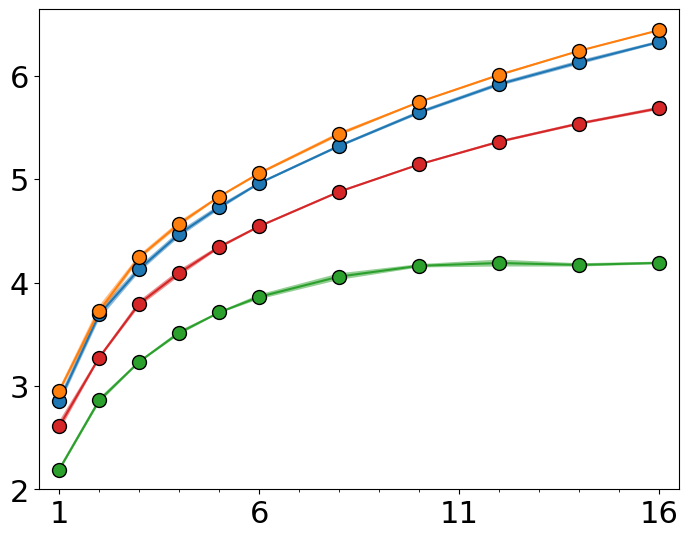

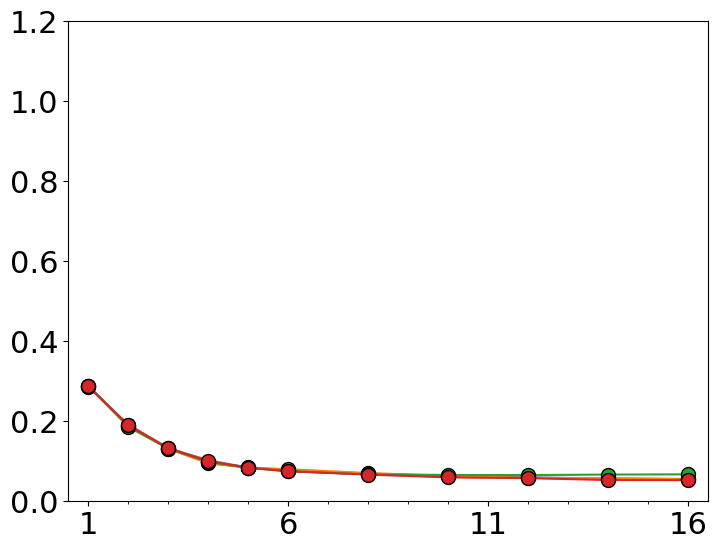

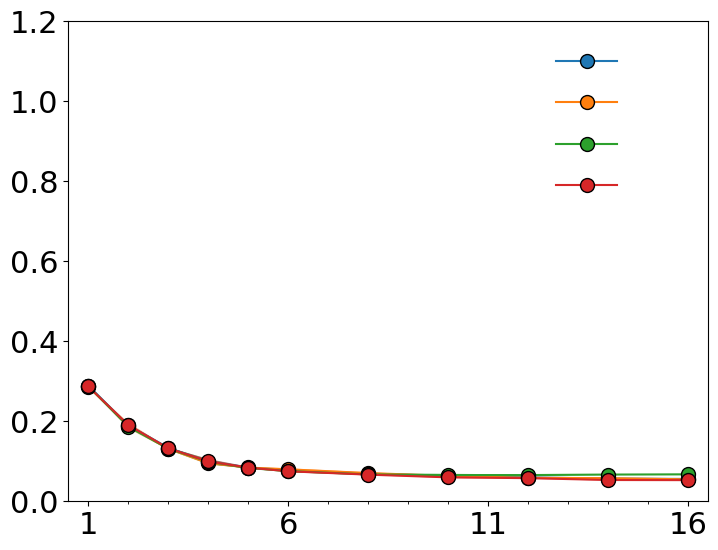

([23, 14], [23, 14], ['C0', 'C1'], ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])


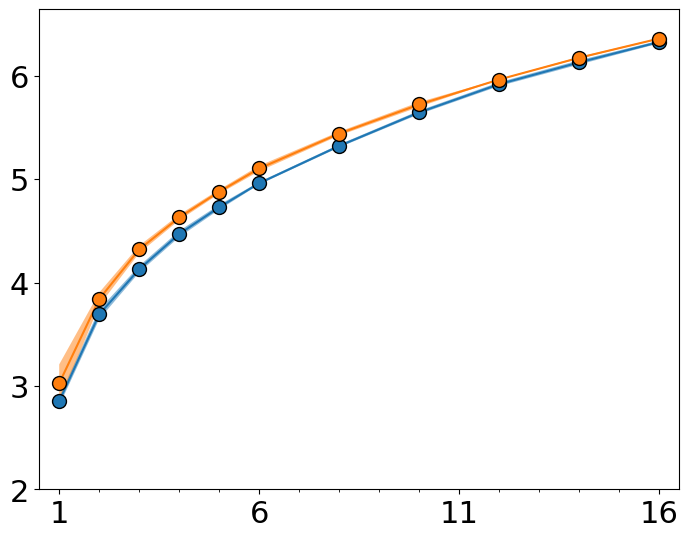

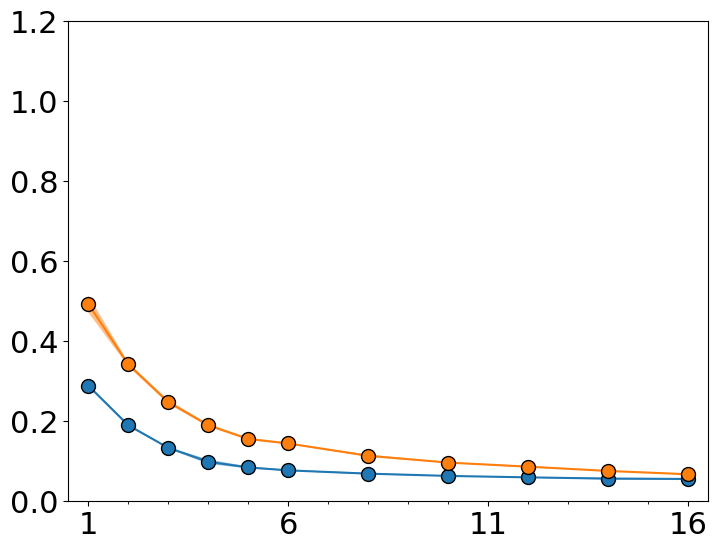

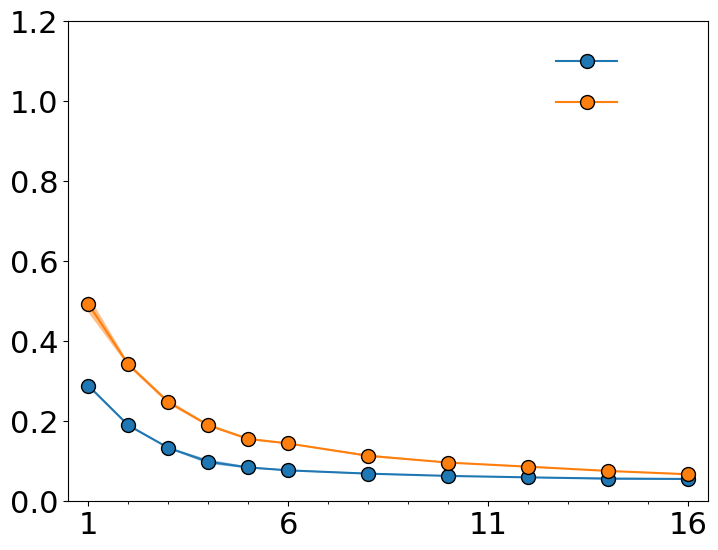

In [33]:
save_plots("beta",rateylim=100,toplot=[base_config_index] + beta_inds)
save_plots("BetaNoTw",rateylim=100,toplot=[base_config_index] + no_tw_beta_inds + [notimewarp_index])

In [34]:
def rate_distortion(namebase,rateylim,latent_dim,toplot,colors=None,shapes=None):
    fsize=(8,6)
    if colors is None:
        colors = [f"C{i}" for i in range(2)]
    if shapes is None:
        shapes = ["o"] * len(datasets)
        
    f = plt.figure(figsize=fsize)
    ax = f.add_axes([0.1, 0.1, 0.8, 0.8])  # add the left Axes
    for i in toplot:
        dataval = datasets[i][0]
        dataval = dataval[dataval[:,0]==latent_dim]
        ax.scatter(dataval[:,5],dataval[:,1],c=colors[0],label=f"Training" if i == 0 else None,marker=shapes[0])
        ax.scatter(dataval[:,5],dataval[:,2],c=colors[1],label=f"Test" if i == 0 else None,marker=shapes[1])
    ax.set_xlim(0,rateylim)
    ax.set_ylim(0,1)
    plt.legend()
    plt.savefig(f"{namebase}RateDistortion.pdf",bbox_inches="tight")
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


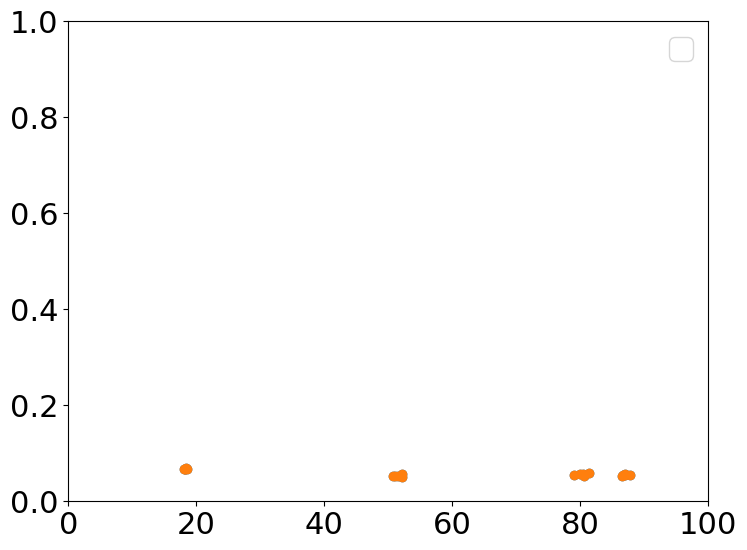

In [35]:
rate_distortion("base",100,16,[base_config_index] + beta_inds,colors=None,shapes=None)

In [36]:
# These base distortion results make sense compared to bottom right of figure 3 in http://proceedings.mlr.press/v130/bozkurt21a/bozkurt21a.pdf
# but they aren't very "excitign"

twvae: [15, 23]
conv: [13, 12]
([15, 23, 13, 12, -2, -1, 26], ['TimewarpVAEbt0.001', 'TimewarpVAEbt0.01', 'Conv0.001', 'Conv0.01', 'DMP', 'PCA', 'RIA'], ['C0', 'C0', 'C1', 'C1', 'C3', 'C2', 'C4'], ['o', 'X', 'o', 'X', '*', '.', '^'])


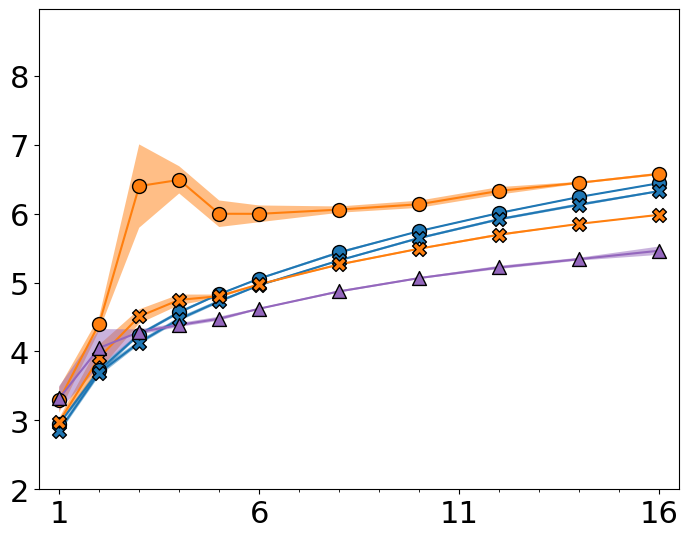

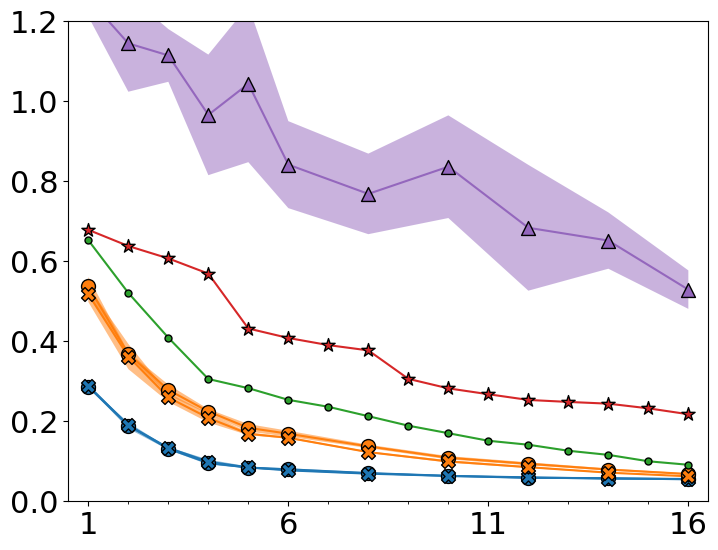

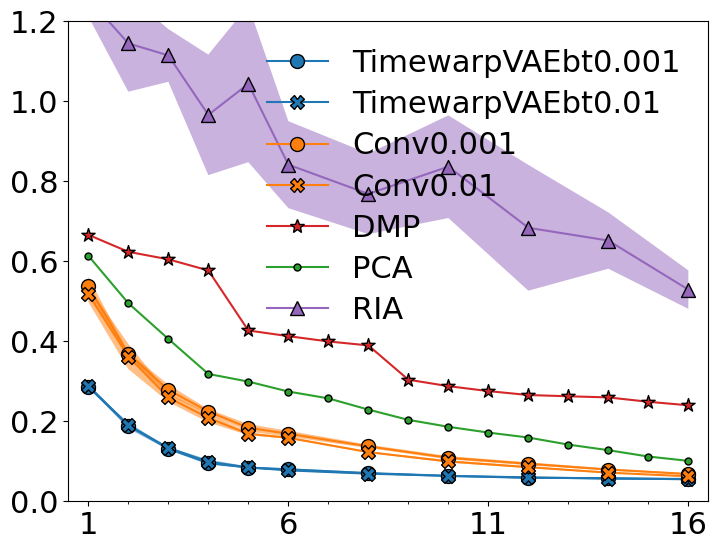

In [37]:
all_conv_inds = conv_beta_inds + [conv_index]
conv_betas = [all_run_dicts[ix]["beta"] for ix in all_conv_inds]
sortorder = np.argsort(conv_betas)
sorted_conv_inds = [all_conv_inds[s] for s in sortorder]
all_timewarpvae_indices =  [base_config_index] + beta_inds
timewarpvae_betas = [all_run_dicts[ix]["beta"] for ix in all_timewarpvae_indices]
twvae_sortorder = np.argsort(timewarpvae_betas)
sorted_twvae_inds = [all_timewarpvae_indices[s] for s in twvae_sortorder]

print("twvae:",sorted_twvae_inds[:2])
print("conv:",sorted_conv_inds)
# just plot the first 2 betas
labels = [f"TimewarpVAEbt{timewarpvae_betas[s]}" for s in twvae_sortorder[1:3]] + [f"Conv{conv_betas[s]}" for s in sortorder[:2]]+ ["DMP"]+ ["PCA"] + ["RIA"]
save_plots("BetaConvTwo",rateylim=500,
           toplot=sorted_twvae_inds[:2] + sorted_conv_inds[:2]+ [-2] + [-1]+ [ria_index], 
           labels=labels,
           colors=["C0"]*2 + ["C1"]*2 +["C3"]+["C2"]+["C4"],
          shapes=["o","X"]*2 + ["*"] + ["."] + ["^"],
          labeltextcolor="black",
          allow_partial=False)

([15, 23, 19, 18, 13, 12], ['TimewarpVAEbt0.0005', 'TimewarpVAEbt0.001', 'TimewarpVAEbt0.01', 'TimewarpVAEbt0.1', 'Conv0.001', 'Conv0.01'], ['C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C1'], ['o', 'P', 'X', '*', 'o', 'P', 'X', '*'])


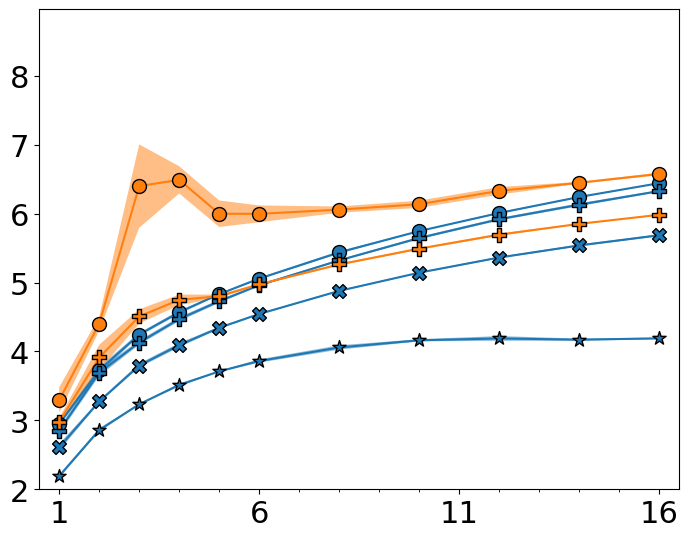

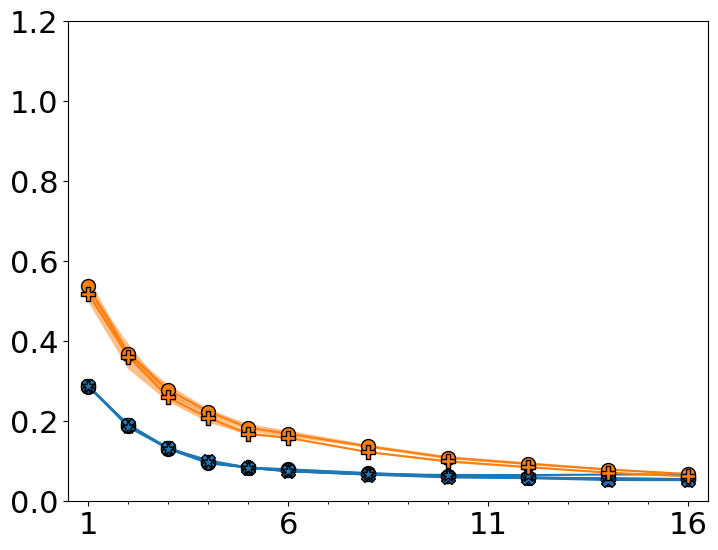

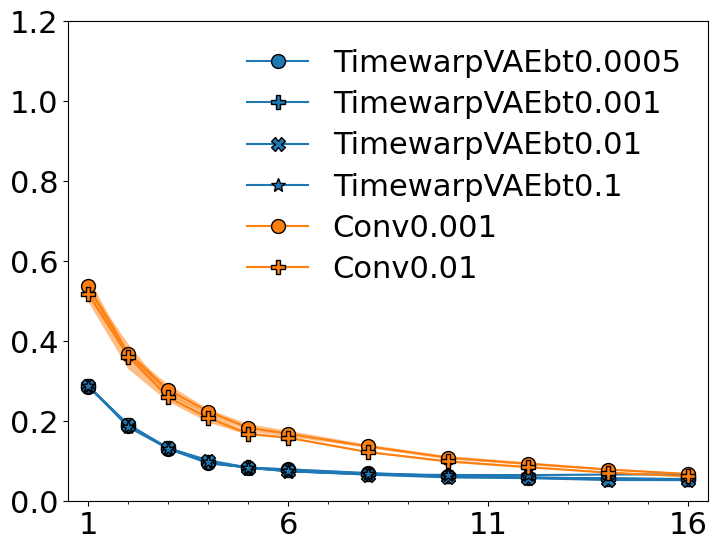

In [38]:
all_conv_inds = conv_beta_inds + [conv_index]
conv_betas = [all_run_dicts[ix]["beta"] for ix in all_conv_inds]
sortorder = np.argsort(conv_betas)
sorted_conv_inds = [all_conv_inds[s] for s in sortorder]
all_timewarpvae_indices =  [base_config_index] + beta_inds
timewarpvae_betas = [all_run_dicts[ix]["beta"] for ix in all_timewarpvae_indices]
twvae_sortorder = np.argsort(timewarpvae_betas)
sorted_twvae_inds = [all_timewarpvae_indices[s] for s in twvae_sortorder]

labels = [f"TimewarpVAEbt{timewarpvae_betas[s]}" for s in twvae_sortorder] + [f"Conv{conv_betas[s]}" for s in sortorder]
save_plots("BetaConv",rateylim=500,toplot=sorted_twvae_inds + sorted_conv_inds, 
           labels=labels,
           colors=["C0"]*4 + ["C1"]*4,
          shapes=["o","P","X","*"]*2,
          labeltextcolor="black")

([23, 10], ['TimewarpVAE', 'beta-VAE DTW---sp'], ['C0', 'C1'], ['o', 'P'])


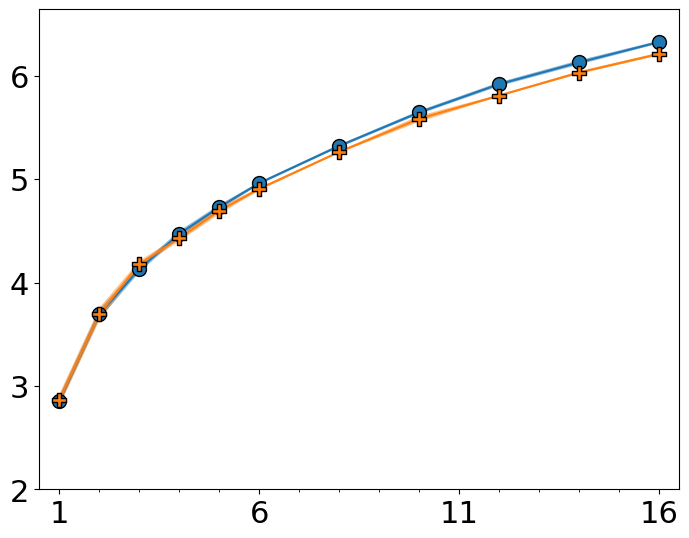

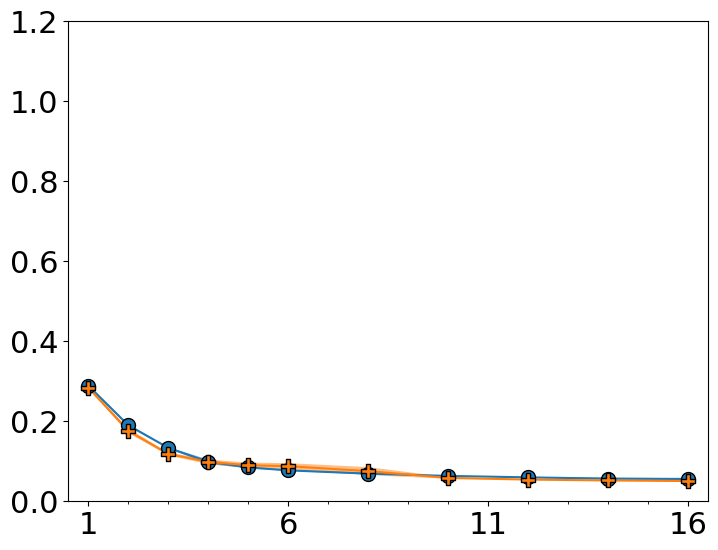

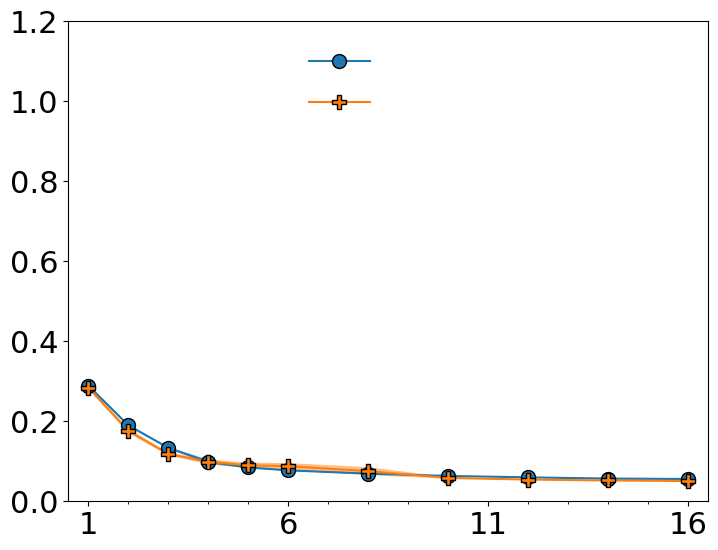

In [39]:
dtw_index
#trans_index
base_config_index

save_plots("TimewarpVAEDTW",rateylim=100,toplot=[base_config_index,dtw_index], 
           labels=["TimewarpVAE", "beta-VAE DTW---sp"],
           colors=["C0","C1"],
          shapes=["o","P"],
          labeltextcolor="white")